# ISDA SIMM homogeneity for portfolio of a single trade

In [1]:
import math
import QuantLib as ql
import scipy
from IPython.core.display import display, Markdown, Image
from numpy.core._multiarray_umath import arange
from collateralAgreement.collateralAgreement import CollateralAgreement, InitialMargining
from instruments.interestRateInstrument.irs import IRS
from jupyterUtils import export
from marketdata.interestRateIndices import InterestRateIndex
from sa_ccr.sa_ccr import SA_CCR
from utilities.Enums import SwapDirection, Currency
from marketdata import init_marketdata
import pandas as pd
import plotly.express as px

We want to showcase that the concentration risk addOn breaks homogeneity of the ISDA SIMM risk measure. The concentration threshold for USD interest rate risk is 230Mn USD per Basis Point change.
Considering that IRS trades roughly have a delta of one against the interest rate this means that a trade with a notional of $\frac{230\text{Mn}}{0.0001} = 2300\text{Bn}$ and a maturity of 1 year would incur a risk above the threshold.
If the maturity increases to 10 years a notional of roughly 230Bn should be enough to exceed the concentration threshold.

In [2]:
notional = 200000000000

irs = IRS(notional = notional,
          timeToSwapStart=ql.Period(2, ql.Days),
          timeToSwapEnd=ql.Period(10, ql.Years),
          swapDirection=SwapDirection.PAYER,
          index = InterestRateIndex.USDLIBOR3M)

simm_sensis = irs.get_simm_sensis()
ir_delta = sum([float(entry['amountUSD']) for entry in simm_sensis if entry['riskType'] == 'Risk_IRCurve'])
ir_delta

177293785.56303406

In [3]:
display(Markdown('The trade has an aggregated delta sensitivity against a 1BP move of the USD interest rate of ' + '{:,.0f}'.format(ir_delta) +' USD. With the available market data the delta of the IRS appears to be slightly lower than one.'))

The trade has an aggregated delta sensitivity against a 1BP move of the USD interest rate of 177,293,786 USD. With the available market data the delta of the IRS appears to be slightly lower than one.

We create a collateral agreement with associated ISDA SIMM and SA CCR model and load the irs in the portfolio.
The collateral agreement uses ISDA SIMM for IM calculation.

In [4]:
ca = CollateralAgreement(initialMargining=InitialMargining.SIMM,
                         margin_currency=Currency.USD)
ca.link_sa_ccr_instance(SA_CCR(ca))
ca.add_trades(irs)

We now want to investigate if the ISDA SIMM exhibits homogeneity for this single trade portfolio.
To do so we test if

\begin{align*}
f\left(\alpha \mathbf{x}\right) = \alpha^k f\left(\mathbf{x}\right) \\
        \text{for } \alpha >0
\end{align*}

 holds. We test for $0<\alpha\leq 2$ with an increment size of 0.01.

In [5]:
bumps = arange(0,2.01,0.01)
resultDataframe = pd.DataFrame(columns = ['USD','k','Legend'])

We create a utility function that supports IM, VM and Collateral although we are just exploring IM right now.

In [6]:
def bump_and_get_results(bumpsize, trade, collateralagreement):
    record = {}
    record['Bumpsize']=bumpsize
    bumped_copy = trade.get_bumped_copy(rel_bump_size=bumpsize-1)
    collateralagreement.remove_all_trades()
    collateralagreement.add_trades(bumped_copy)
    record['IM'] = collateralagreement.get_im_model().get_risk_measure()
    record['VM'] = collateralagreement.get_vm_model().get_risk_measure()
    record['Collateral'] = collateralagreement.get_C()
    collateralagreement.remove_all_trades()
    collateralagreement.add_trades(trade)
    return record

In [7]:
for bump in bumps:
    result = bump_and_get_results(bump, irs, ca)
    im_record = {'X': result['Bumpsize'],
                 'Y': result['IM'],
                 'Legend': 'IM'}
    resultDataframe = resultDataframe.append(im_record, ignore_index=True)

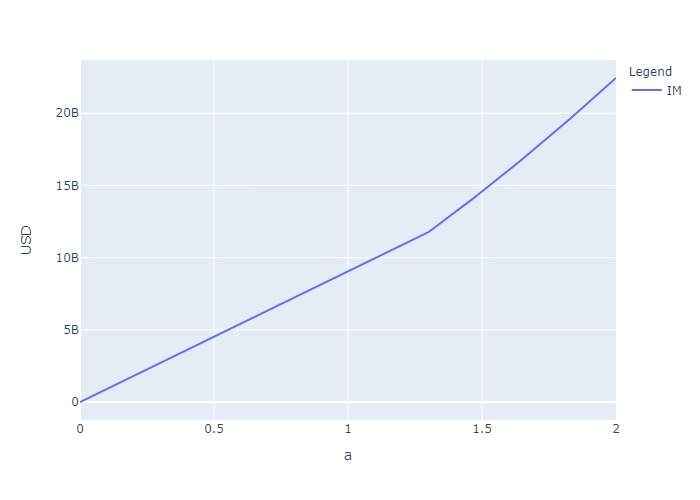

In [8]:
fig = px.line(resultDataframe[resultDataframe.Legend == 'IM'], x='X', y='Y', color='Legend', line_dash='Legend')
fig.update_layout(xaxis_title = 'a', yaxis_title = 'USD')
img_bytes = fig.to_image(format='jpeg')
Image(img_bytes)

As can be seen, ISDA SIMM does not exhibit homogeneity.
We can find the notional at which the IR delta of the trade exceed 230Mn USD.

In [9]:
def aggregate_usd_ir_by_notional(notional):
    irs2 = IRS(notional = notional,
           timeToSwapStart=ql.Period(2, ql.Days),
           timeToSwapEnd=ql.Period(10, ql.Years),
           swapDirection=SwapDirection.PAYER,
           index = InterestRateIndex.USDLIBOR3M)
    irs2.get_simm_sensis_ircurve()
    delta = sum([float(k['amount']) for k in irs2.get_simm_sensis_ircurve()])
    return (delta-230000000)**2

res = scipy.optimize.minimize_scalar(
    aggregate_usd_ir_by_notional,
    bounds = (1, 10e12),
    method = 'bounded')
f'Notional: {res.x:,.0f} USD'

'Notional: 259,456,358,913 USD'

In [10]:
'a: %.2f'%(res.x / irs.notional)

'a: 1.30'

Further discussion of this in section \ref{Allocation of initial margin}.

In [12]:
export('ISDA SIMM homogeneity for a single trade.ipynb')